<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Papers/blob/main/DenseNet_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

tf.__version__

'2.11.0'

#Data 
[Source](https://www.kaggle.com/datasets/csafrit2/plant-leaves-for-image-classification)

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d csafrit2/plant-leaves-for-image-classification
!unzip \*.zip && rm .zip

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/Plants_2/train/',
    labels = 'inferred',
    label_mode = 'int', # categorical, binary
    class_names = None,
    color_mode = 'rgb', #grayscale
    batch_size = 32,
    image_size = (128, 128), #Reshape if not in this size
    shuffle=True,
    seed=32,
    validation_split=None,
    subset=None)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/Plants_2/valid/',
    labels = 'inferred',
    label_mode = 'int', # categorical, binary
    class_names = None,
    color_mode = 'rgb', #grayscale
    batch_size = 32,
    image_size = (128, 128), #Reshape if not in this size
    shuffle=True,
    seed=32,
    validation_split=None,
    subset=None)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = '/content/Plants_2/test/',
    labels = 'inferred',
    label_mode = 'int', # categorical, binary
    class_names = None,
    color_mode = 'rgb', #grayscale
    batch_size = 32,
    image_size = (128, 128), #Reshape if not in this size
    shuffle=True,
    seed=32,
    validation_split=None,
    subset=None)

Found 4274 files belonging to 22 classes.
Found 110 files belonging to 22 classes.
Found 110 files belonging to 22 classes.


In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    rotation_range=5,
    zoom_range = (0.95, 0.95),
    horizontal_flip=False,
    vertical_flip=False,
    data_format='channels_last', #channels_last
    validation_split=0.0,
    dtype=tf.float32
)

train_gen = train_datagen.flow_from_directory('/content/Plants_2/train/',
                                        target_size=(128, 128),
                                        batch_size=32,
                                        color_mode='rgb',
                                        class_mode='categorical', #binary, sparse
                                        shuffle=True,
                                        subset=None)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

validation_gen = test_datagen.flow_from_directory('/content/Plants_2/test/',
                                        target_size=(128, 128),
                                        batch_size=32,
                                        color_mode='rgb',
                                        class_mode='categorical', #binary, sparse
                                        shuffle=True,
                                        subset=None)

Found 4274 images belonging to 22 classes.
Found 110 images belonging to 22 classes.


In [4]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)


In [6]:
train_ds.class_names

['Alstonia Scholaris diseased (P2a)',
 'Alstonia Scholaris healthy (P2b)',
 'Arjun diseased (P1a)',
 'Arjun healthy (P1b)',
 'Bael diseased (P4b)',
 'Basil healthy (P8)',
 'Chinar diseased (P11b)',
 'Chinar healthy (P11a)',
 'Gauva diseased (P3b)',
 'Gauva healthy (P3a)',
 'Jamun diseased (P5b)',
 'Jamun healthy (P5a)',
 'Jatropha diseased (P6b)',
 'Jatropha healthy (P6a)',
 'Lemon diseased (P10b)',
 'Lemon healthy (P10a)',
 'Mango diseased (P0b)',
 'Mango healthy (P0a)',
 'Pomegranate diseased (P9b)',
 'Pomegranate healthy (P9a)',
 'Pongamia Pinnata diseased (P7b)',
 'Pongamia Pinnata healthy (P7a)']

In [39]:
class DenseNet(tf.keras.Model):
  def __init__(self, x, n_blocks, filters, training):
    self.filters = filters
    self.training = training
    self.n_blocks = n_blocks
    self.model = self.Dense_net(x)

  def dense_block(self, input_x, n_layers, layer_name, drop_rate=0.2, kernel_1=1, kernel_2=3):
    with tf.name_scope(layer_name):   #Remove or Not????
      
      previous_input = input_x

      for i in range(n_layers):

        x = tf.keras.layers.BatchNormalization(axis=-1, name=layer_name+layer_name+'DenseBlock_BatchNormLayer_1')(x),
        x = tf.keras.layers.Conv2D(filters=4*self.filters, kernel_size=kernel_1, activation='relu', name=layer_name+'DenseBlock_1X1ConvLayer')(x),
        x = tf.keras.layers.Dropout(rate=drop_rate, name=layer_name+'DenseBlock_DropLayer_1')(x),
        x = tf.keras.layers.BatchNormalization(axis=-1, name=layer_name+'DenseBlock_BatchNormLayer_2')(x),
        x = tf.keras.layers.Conv2D(filters=self.filters, kernel_size=kernel_2, activation='relu', name=layer_name+'DenseBlock_3X3ConvLayer')(x),
        x = tf.keras.layers.Dropout(rate=drop_rate, name=layer_name+'DenseBlock_DropLayer_2')(x)

        x = tf.keras.layers.Concatenate(axis=-1)([x, previous_input])  #Concatenate channel wise
        previous_input = x

    return x


  def transition_layer(self, x, scope, kernel=1, drop_rate=0.2):
    with tf.name_scope(scope):
      
      x = tf.keras.layers.BatchNormalization(axis=-1, name=scope+'Transition_BatchNormLayer')(x)
      x = tf.keras.layers.Conv2D(filters=self.filters, kernel=kernel, activation='relu', name=scope+'Transition_1X1ConvLayer')(x)
      x = tf.keras.layers.Dropout(rate=drop_rate)
      x = tf.keras.layers.AveragePooling2D(pool_size=2, stride=2)
      # x = tf.keras.layers.GlobalAveragePooling2D(pool_size=2, stride=2)
      # x = tf.keras.layers.MaxPooling2D(pool_size=2, stride=2)
      return x


  def Dense_net(self, input_x):
    x = tf.keras.layers.Conv2D(filters=self.filters, activation='relu', kernel=3, input_shape=(128, 128, 3))
    x = tf.keras.layers.MaxPool2D(pool_size=3, stride=2)(x)
    # x = tf.keras.layers.GlobalMaxPool2D(pool_size=3, stride=2)(x)


    for i in range(self.n_blocks): #6-->12-->48
      x = self.dense_block(x, 4, f'Dense_Layer{i}')
      x = self.transition_layer(x, f'Transition_Layer{i}')


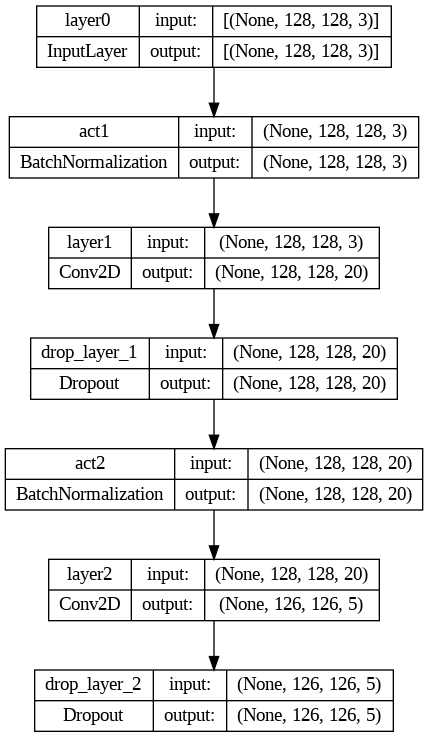

In [33]:
model.layers
tf.keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)
# model.weights